# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [29]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.372473
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 
There are ten classes, with random weights, all classes should be equally probable. Therefore it is 1/10=0.1 


In [30]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.008523 analytic: -0.008524, relative error: 5.705374e-06
numerical: 0.801568 analytic: 0.801568, relative error: 3.563611e-08
numerical: 4.226120 analytic: 4.226120, relative error: 1.978579e-08
numerical: 0.586917 analytic: 0.586917, relative error: 2.629271e-08
numerical: -1.278199 analytic: -1.278199, relative error: 2.866917e-08
numerical: -5.857762 analytic: -5.857762, relative error: 6.230072e-09
numerical: 1.446634 analytic: 1.446633, relative error: 7.362025e-09
numerical: -1.517373 analytic: -1.517373, relative error: 1.135607e-08
numerical: 0.240660 analytic: 0.240660, relative error: 1.543488e-07
numerical: 0.432777 analytic: 0.432777, relative error: 6.270987e-08
numerical: -0.254004 analytic: -0.254004, relative error: 2.427939e-07
numerical: -2.114270 analytic: -2.114270, relative error: 4.559130e-09
numerical: -1.202763 analytic: -1.202763, relative error: 1.071065e-08
numerical: -2.514878 analytic: -2.514879, relative error: 2.482907e-08
numerical: -0.2340

In [36]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.372473e+00 computed in 0.067692s
vectorized loss: 2.372473e+00 computed in 0.002929s
Loss difference: 0.000000
Gradient difference: 0.000000


In [41]:
from cs231n.classifiers import Softmax
softmax = Softmax()
loss_hist = softmax.train(X_dev, y_dev, learning_rate=1e-6, reg=0.000001,
                      num_iters=10000, verbose=True)
y_dev_pred = softmax.predict(X_dev)
print('accuracy: %f' %(np.mean(y_dev==y_dev_pred)))

iteration 0 / 10000: loss 5.667983
iteration 100 / 10000: loss 1.694097
iteration 200 / 10000: loss 1.431847
iteration 300 / 10000: loss 1.255920
iteration 400 / 10000: loss 0.960477
iteration 500 / 10000: loss 0.801305
iteration 600 / 10000: loss 0.676476
iteration 700 / 10000: loss 0.620766
iteration 800 / 10000: loss 0.597745
iteration 900 / 10000: loss 0.536494
iteration 1000 / 10000: loss 0.469061
iteration 1100 / 10000: loss 0.404634
iteration 1200 / 10000: loss 0.381021
iteration 1300 / 10000: loss 0.448190
iteration 1400 / 10000: loss 0.384352
iteration 1500 / 10000: loss 0.316258
iteration 1600 / 10000: loss 0.284823
iteration 1700 / 10000: loss 0.276029
iteration 1800 / 10000: loss 0.255772
iteration 1900 / 10000: loss 0.305042
iteration 2000 / 10000: loss 0.218059
iteration 2100 / 10000: loss 0.221109
iteration 2200 / 10000: loss 0.202693
iteration 2300 / 10000: loss 0.186542
iteration 2400 / 10000: loss 0.191012
iteration 2500 / 10000: loss 0.183268
iteration 2600 / 10000: 

In [42]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
# learning_rates = [1e-7, 5e-7]
# regularization_strengths = [2.5e4, 5e4]

################################################################################`
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# for learning_rate in learning_rates:
#     for reg in regularization_strengths:
for i in range(15):
    reg = 10 ** random.uniform(3.5, 4.5)
    learning_rate = 10 ** random.uniform(-6.2, -6.7)
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                  num_iters=3000, verbose=False)

    y_train_pred = softmax.predict(X_train)
    acc_train = np.mean(y_train == y_train_pred)

    y_val_pred = softmax.predict(X_val)
    acc_val = np.mean(y_val == y_val_pred)
    if acc_val > best_val:
        best_val=acc_val
        best_softmax= softmax
    results[(learning_rate,reg)] = (acc_train,acc_val)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                np.log10(lr), np.log10(reg), train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr -6.615929e+00 reg 3.725213e+00 train accuracy: 0.371184 val accuracy: 0.383000
lr -6.572594e+00 reg 3.603363e+00 train accuracy: 0.379592 val accuracy: 0.389000
lr -6.535412e+00 reg 3.602506e+00 train accuracy: 0.375306 val accuracy: 0.390000
lr -6.528889e+00 reg 4.222764e+00 train accuracy: 0.346000 val accuracy: 0.352000
lr -6.489569e+00 reg 3.595491e+00 train accuracy: 0.374122 val accuracy: 0.381000
lr -6.459052e+00 reg 3.829247e+00 train accuracy: 0.362796 val accuracy: 0.369000
lr -6.455461e+00 reg 4.030451e+00 train accuracy: 0.350388 val accuracy: 0.359000
lr -6.443623e+00 reg 4.336166e+00 train accuracy: 0.329204 val accuracy: 0.344000
lr -6.409073e+00 reg 4.172789e+00 train accuracy: 0.349204 val accuracy: 0.362000
lr -6.375661e+00 reg 4.257046e+00 train accuracy: 0.339612 val accuracy: 0.347000
lr -6.345315e+00 reg 3.766526e+00 train accuracy: 0.368082 val accuracy: 0.382000
lr -6.317473e+00 reg 4.483381e+00 train accuracy: 0.318469 val accuracy: 0.334000
lr -6.284362e+00

In [43]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.377000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:True

*Your explanation*:If new data point is creating score above the margin, its contribution will be zero, but in case of softmax, it will further try to take it away.

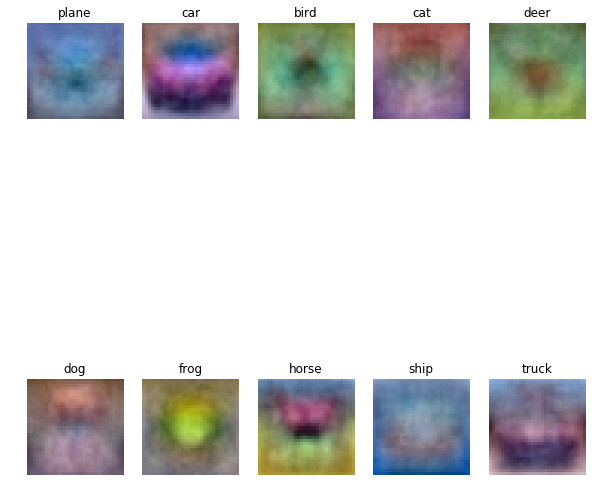

In [44]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,12))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])